In [1]:
from kan import KAN, LBFGS
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import time

In [2]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

In [3]:
# Check for NaN or Inf values in input data
def check_for_nan_inf(tensor, name):
    if torch.isnan(tensor).any():
        raise ValueError(f"NaN values found in {name}")
    if torch.isinf(tensor).any():
        raise ValueError(f"Inf values found in {name}")

In [15]:
# def loss_fun(t_int,x_int,t_bc,x_bc,t_ic,x_ic, model):
#     input_tensor = torch.cat((t_int, x_int), dim=1)
#     u = model(input_tensor)
#     u_t = torch.autograd.grad(
#             u, t_int,
#             grad_outputs=torch.ones_like(t_int),
#             create_graph=True)[0]
#     u_x = torch.autograd.grad(
#             u, x_int,
#             grad_outputs=torch.ones_like(x_int),
#             create_graph=True)[0]
#     u_xx = torch.autograd.grad(
#             u_x, x_int,
#             grad_outputs=torch.ones_like(x_int),
#             create_graph=True)[0]
#     R_int = torch.mean(torch.square(u_t + u * u_x - (0.01/torch.pi) * u_xx))
    
#     input_tensor = torch.cat((t_bc,x_bc), dim=1)
#     u_bc = model(input_tensor)
#     R_bc  = torch.mean(torch.square(u_bc))
    
#     input_tensor = torch.cat((t_ic,x_ic), dim=1)
#     u_ic = model(input_tensor)
#     R_ic  = torch.mean(torch.square(u_ic + torch.sin(x_train * torch.pi )))

#     return R_int,R_bc,R_ic



def loss_fun(t_int, x_int, t_bc, x_bc, t_ic, x_ic, model):
    input_tensor = torch.cat((t_int, x_int), dim=1)
    u = model(input_tensor)
    print("Shape of output tensor: " + str(u.shape))
    u_t = torch.autograd.grad(
        u, t_int,
        grad_outputs=torch.ones_like(t_int),
        create_graph=True)[0]
    print("Shape of t_int: " + str(t_int.shape))
    print("Shape of u_t: " + str(u_t.shape))
    u_x = torch.autograd.grad(
        u, x_int,
        grad_outputs=torch.ones_like(x_int),
        create_graph=True)[0]
    print("Shape of u_x: " + str(u_x.shape))
    u_xx = torch.autograd.grad(
        u_x, x_int,
        grad_outputs=torch.ones_like(x_int),
        create_graph=True)[0]
    print("Shape of u_xx: " + str(u_xx.shape))

    R_int = torch.mean(torch.square(u_t + u * u_x - (0.01 / torch.pi) * u_xx))
    check_for_nan_inf(R_int, "R_int")

    input_tensor = torch.cat((t_bc, x_bc), dim=1)
    u_bc = model(input_tensor)
    R_bc = torch.mean(torch.square(u_bc))
    check_for_nan_inf(R_bc, "R_bc")

    input_tensor = torch.cat((t_ic, x_ic), dim=1)
    u_ic = model(input_tensor)
    R_ic = torch.mean(torch.square(u_ic + torch.sin(x_train * torch.pi)))
    check_for_nan_inf(R_ic, "R_ic")

    return R_int, R_bc, R_ic


In [6]:
# Interior points
sampling_mode = 'mesh'  # 'random' or 'mesh'

N              = 100
t_train        = torch.linspace(0, 0.5, N, requires_grad=True).reshape(N,1)
x_train        = torch.linspace(-1, 1, N, requires_grad=True).reshape(N,1)


if sampling_mode == 'mesh':
    # Generate interior t,x
    t_int, x_int = torch.meshgrid(t_train[1:].squeeze(), x_train[1:-1].squeeze())
    print(t_int.shape, x_int.shape)
    t_int = t_int.reshape(-1, 1)
    x_int = x_int.reshape(-1, 1)
    print(t_int.shape, x_int.shape)
else:
    pass

# Generate boundary t,x
t_bc,x_bc = torch.meshgrid(t_train.squeeze(), torch.cat((x_train[:1], x_train[-1:]), dim=0).squeeze())
print(t_bc.shape, x_bc.shape)
t_bc = t_bc.reshape(-1, 1)
x_bc = x_bc.reshape(-1, 1)
print(t_bc.shape, x_bc.shape)

# Generate initial t,x
t_ic,x_ic = torch.meshgrid(t_train[:1].squeeze(), x_train.squeeze())
t_ic = t_ic.reshape(-1, 1)
x_ic = x_ic.reshape(-1, 1)

torch.Size([99, 98]) torch.Size([99, 98])
torch.Size([9702, 1]) torch.Size([9702, 1])
torch.Size([100, 2]) torch.Size([100, 2])
torch.Size([200, 1]) torch.Size([200, 1])


In [10]:
lambda_b       = 10.0
lambda_ic      =10.0

steps = 20
alpha = 0.1
log = 1

global loss_int_hist, loss_bc_hist, loss_ic_hist, pred_hist

pred_hist      = np.zeros(N)

model = KAN(width=[2, 10, 5, 3,  1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

In [11]:
# def train(steps):

#     loss_int_hist  = np.zeros(steps)
#     loss_bc_hist    = np.zeros(steps)
#     loss_ic_hist    = np.zeros(steps)
    
#     pbar = tqdm(range(steps), desc='description')
#     # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)

#     for epoch in pbar:
#         def closure():
#             global loss_int, loss_bc, loss_ic

#             # zero the gradient buffers
#             optimizer.zero_grad()
#             # compute losses
#             loss_int,loss_bc,loss_ic = loss_fun(t_int,x_int,t_bc,x_bc,t_ic,x_ic, model)
#             loss = loss_int + lambda_b*loss_bc + lambda_ic*loss_ic
#             # compute gradients of training loss
#             loss.backward()
            
#             return loss

#         input_tensor = torch.cat((t_int, x_int), dim=1)
#         if epoch % 5 == 0 and epoch < 50:
#             model.update_grid_from_samples(input_tensor)

#         optimizer.step(closure)
#         loss = loss_int + lambda_b*loss_bc + lambda_ic*loss_ic

#         if epoch % log == 0:
#             pbar.set_description("interior pde loss: %.2e | bc loss: %.2e | ic loss: %.2e " % (loss_int.cpu().detach().numpy(), loss_bc.cpu().detach().numpy(), loss_ic.detach().numpy()))

#         # print(f'   --- epoch {epoch+1}: loss_int = {loss_int.item():.4e}, loss_bc = {loss_bc.item():.4e}, loss_ic = {loss_ic.item():.4e}')
        
#         # save loss
#         loss_int_hist[epoch] = loss_int
#         loss_bc_hist[epoch] = loss_bc
#         loss_ic_hist[epoch] = loss_ic




# Train function with added checks
def train(steps):
    loss_int_hist = np.zeros(steps)
    loss_bc_hist = np.zeros(steps)
    loss_ic_hist = np.zeros(steps)

    pbar = tqdm(range(steps), desc='description')

    for epoch in pbar:
        def closure():
            global loss_int, loss_bc, loss_ic

            optimizer.zero_grad()
            loss_int, loss_bc, loss_ic = loss_fun(t_int, x_int, t_bc, x_bc, t_ic, x_ic, model)
            loss = loss_int + lambda_b * loss_bc + lambda_ic * loss_ic

            if torch.isnan(loss) or torch.isinf(loss):
                raise ValueError("NaN or Inf detected in loss")

            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            return loss

        input_tensor = torch.cat((t_int, x_int), dim=1)
        print("Shape of input tensor: " + str(input_tensor.shape))
        if epoch % 5 == 0 and epoch < 50:
            try:
                model.update_grid_from_samples(input_tensor)
            except Exception as e:
                print(f"Error during update_grid_from_samples: {e}")
                continue

        try:
            optimizer.step(closure)
        except Exception as e:
            print(f"Error during optimizer step: {e}")
            continue

        loss = loss_int + lambda_b * loss_bc + lambda_ic * loss_ic

        if torch.isnan(loss) or torch.isinf(loss):
            print("NaN or Inf detected in loss after optimizer step")
            continue

        if epoch % log == 0:
            pbar.set_description(
                "interior pde loss: %.2e | bc loss: %.2e | ic loss: %.2e " % (
                    loss_int.cpu().detach().numpy(),
                    loss_bc.cpu().detach().numpy(),
                    loss_ic.detach().numpy())
            )

        loss_int_hist[epoch] = loss_int.item()
        loss_bc_hist[epoch] = loss_bc.item()
        loss_ic_hist[epoch] = loss_ic.item()

In [16]:
# Measure execution time
start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

description:   0%|          | 0/20 [00:00<?, ?it/s]

Shape of input tensor: torch.Size([9702, 2])
Shape of output tensor: torch.Size([9702, 1])
Shape of t_int: torch.Size([9702, 1])
Shape of u_t: torch.Size([9702, 1])
Shape of u_x: torch.Size([9702, 1])
Shape of u_xx: torch.Size([9702, 1])
Shape of output tensor: torch.Size([9702, 1])
Shape of t_int: torch.Size([9702, 1])
Shape of u_t: torch.Size([9702, 1])
Shape of u_x: torch.Size([9702, 1])
Shape of u_xx: torch.Size([9702, 1])
Shape of output tensor: torch.Size([9702, 1])
Shape of t_int: torch.Size([9702, 1])
Shape of u_t: torch.Size([9702, 1])
Shape of u_x: torch.Size([9702, 1])
Shape of u_xx: torch.Size([9702, 1])
Shape of output tensor: torch.Size([9702, 1])
Shape of t_int: torch.Size([9702, 1])
Shape of u_t: torch.Size([9702, 1])
Shape of u_x: torch.Size([9702, 1])
Shape of u_xx: torch.Size([9702, 1])


description:   0%|          | 0/20 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [9]:
# Measure execution time
start_time = time.time()

train(5)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

interior pde loss: 1.34e-02 | bc loss: 1.22e-05 | ic loss: 2.58e-04 : 100%|██████████| 5/5 [08:02<00:00, 96.55s/it] 

Training completed in 482.75 seconds.


In [10]:
# Measure execution time
start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

interior pde loss: 8.80e-03 | bc loss: 1.56e-05 | ic loss: 1.71e-04 :  25%|██▌       | 5/20 [06:49<20:28, 81.92s/it]


KeyboardInterrupt: 

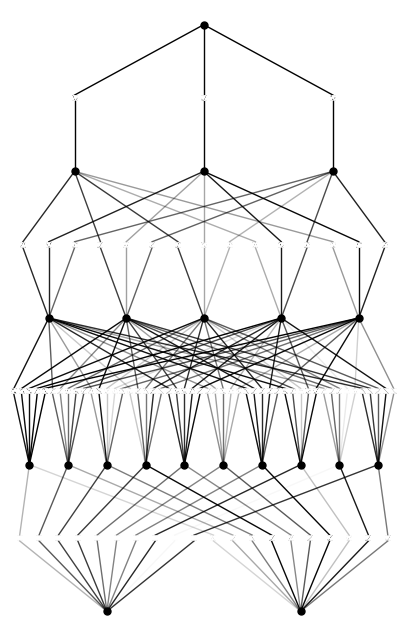

In [11]:
model.plot(beta=10)

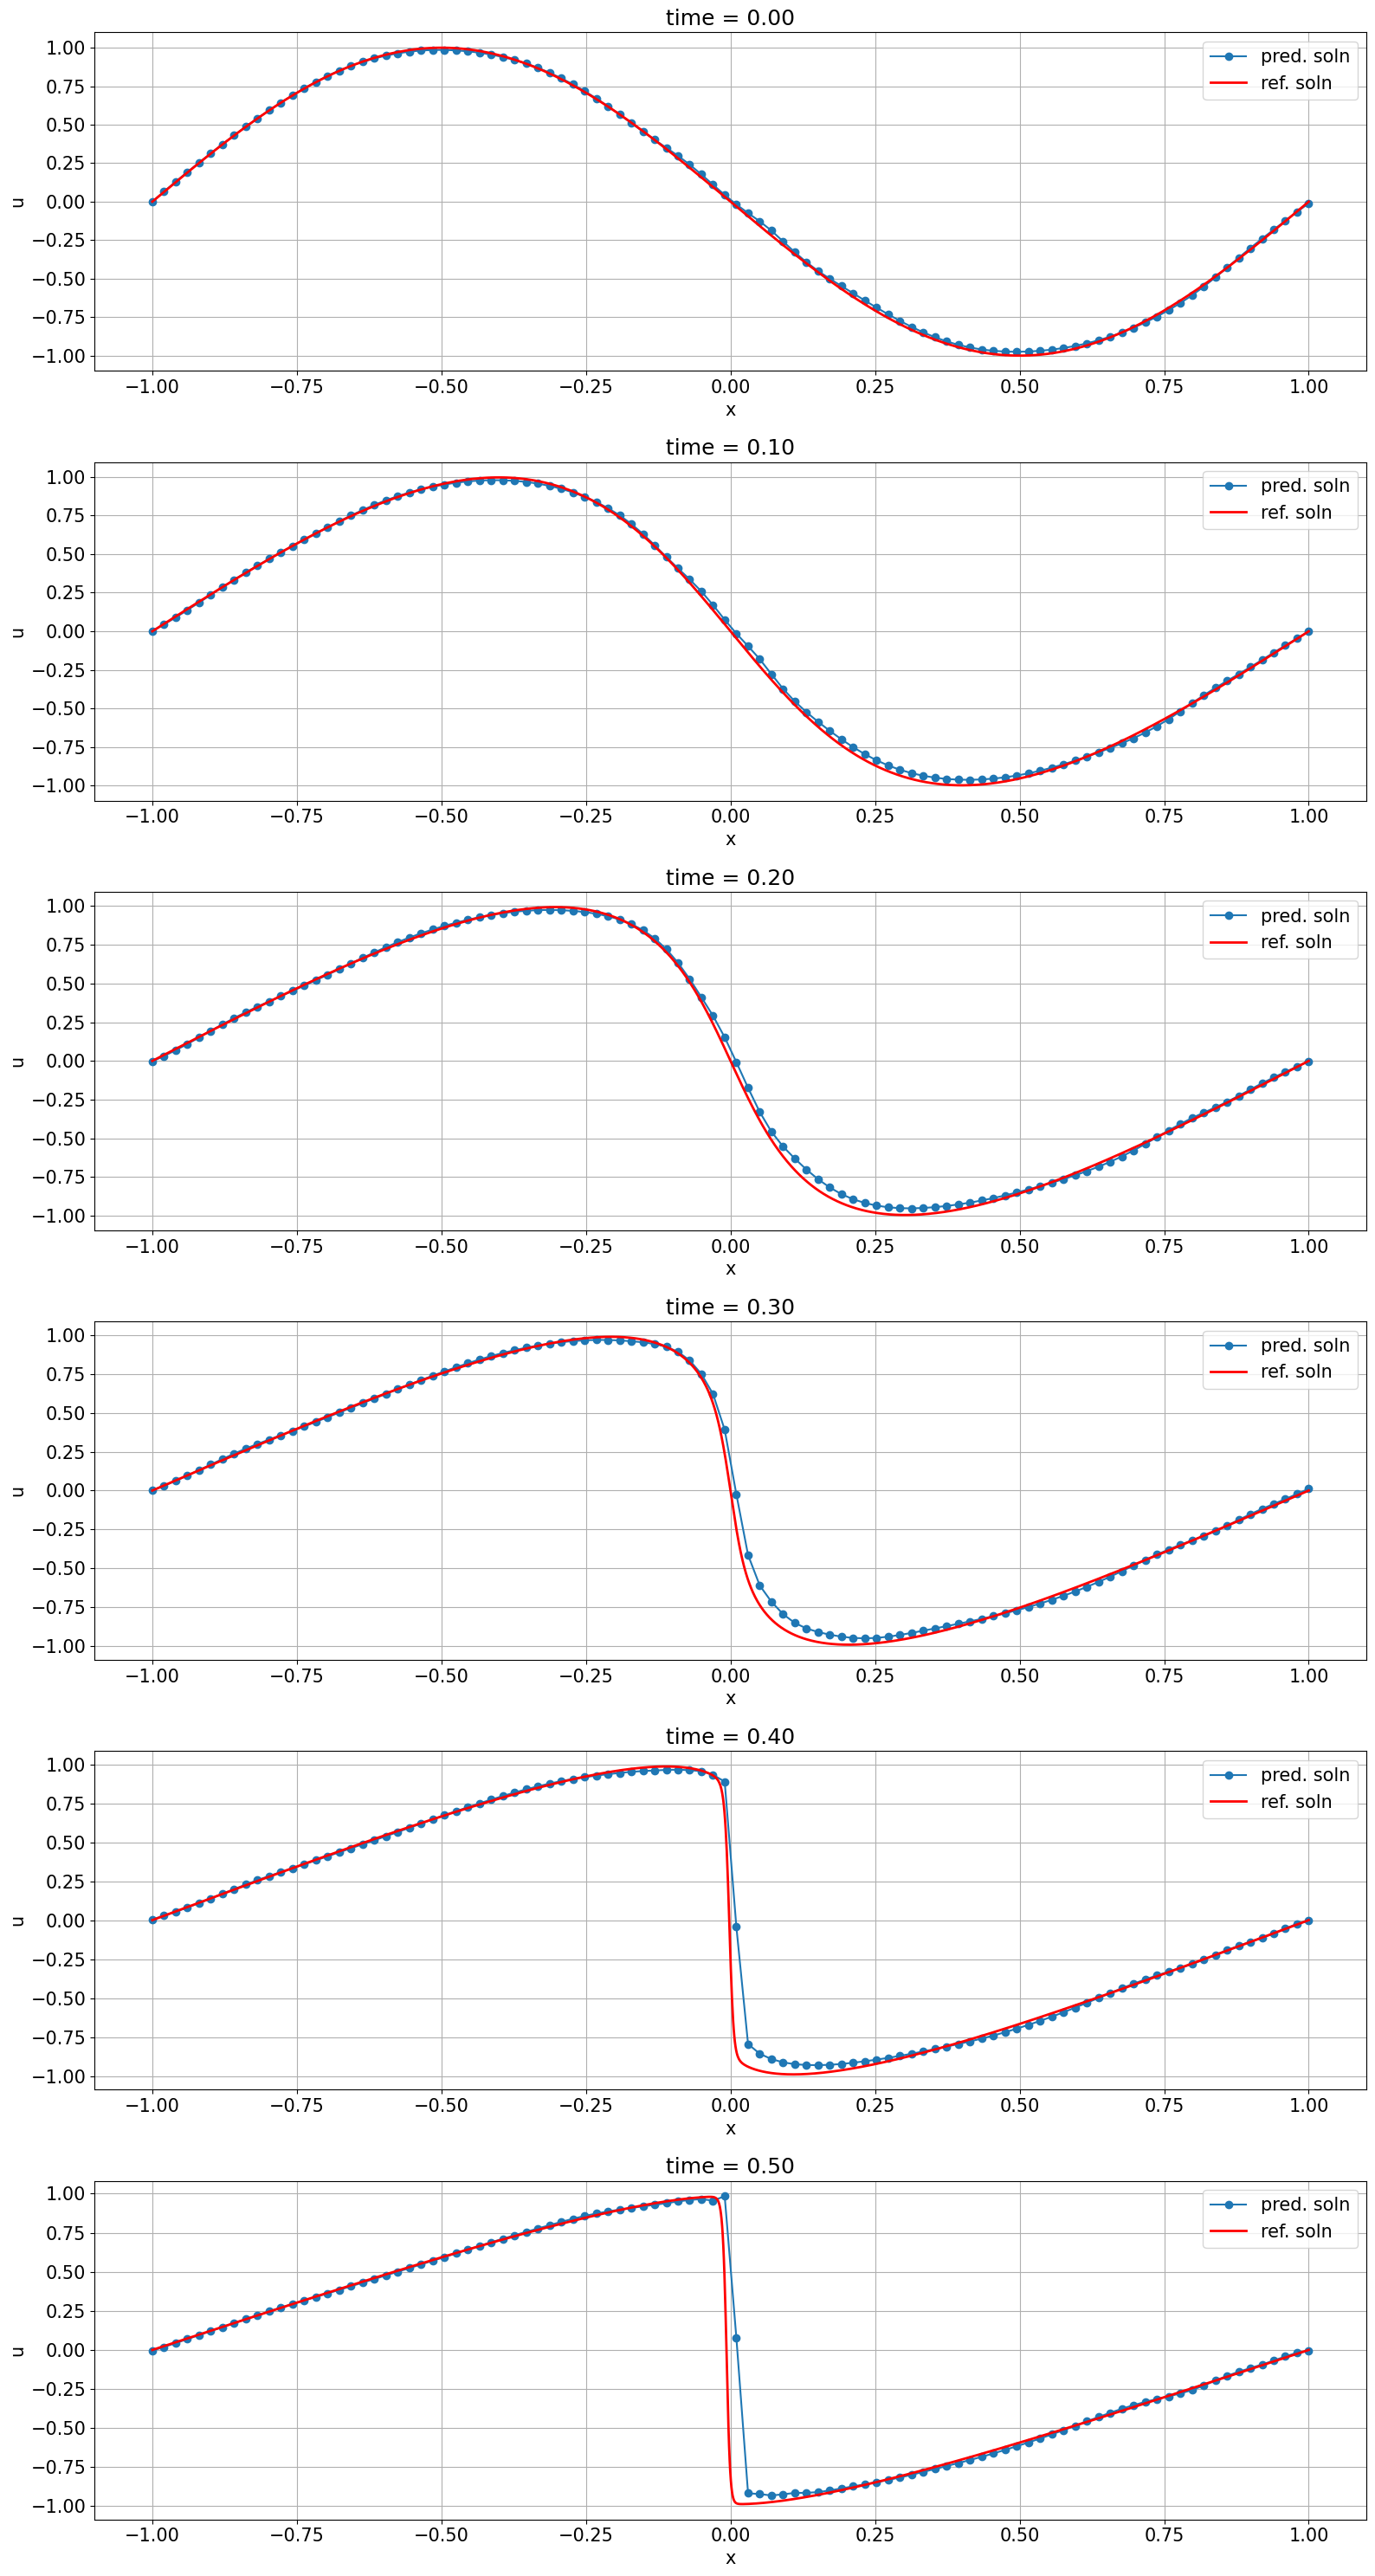

In [12]:
# Visualization
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0, .1, .2, .3, .4, .5])
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(t_sample), 1, figsize=(16, 5 * len(t_sample)))

for l, sample in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(sample, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(torch.cat((t_test, x_test), dim=1)).detach().numpy()

    ax[l].plot(x_test.detach().numpy(), pred_hist, marker='o', label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {sample:.2f}')

fig.tight_layout()
plt.savefig('Burgers_Equation_KAN.jpeg', format='jpeg')

Applying fix_symbolic at layer 0, input neuron 0, output neuron 0
Successfully applied fix_symbolic at layer 0, input neuron 0, output neuron 0
Applying fix_symbolic at layer 0, input neuron 0, output neuron 1
Successfully applied fix_symbolic at layer 0, input neuron 0, output neuron 1
Applying fix_symbolic at layer 0, input neuron 0, output neuron 2
Successfully applied fix_symbolic at layer 0, input neuron 0, output neuron 2
Applying fix_symbolic at layer 0, input neuron 0, output neuron 3
Successfully applied fix_symbolic at layer 0, input neuron 0, output neuron 3
Applying fix_symbolic at layer 0, input neuron 0, output neuron 4
Successfully applied fix_symbolic at layer 0, input neuron 0, output neuron 4
Applying fix_symbolic at layer 0, input neuron 1, output neuron 0
Successfully applied fix_symbolic at layer 0, input neuron 1, output neuron 0
Applying fix_symbolic at layer 0, input neuron 1, output neuron 1
Successfully applied fix_symbolic at layer 0, input neuron 1, output n

description:   5%|▌         | 1/20 [00:01<00:23,  1.23s/it]

Error during optimizer step: Inf values found in R_int


description:  10%|█         | 2/20 [00:02<00:18,  1.02s/it]

Error during optimizer step: Inf values found in R_int


description:  15%|█▌        | 3/20 [00:02<00:14,  1.15it/s]

Error during optimizer step: Inf values found in R_int


description:  20%|██        | 4/20 [00:03<00:12,  1.28it/s]

Error during optimizer step: Inf values found in R_int


description:  25%|██▌       | 5/20 [00:04<00:11,  1.29it/s]

Error during optimizer step: Inf values found in R_int


description:  30%|███       | 6/20 [00:05<00:13,  1.02it/s]

Error during optimizer step: Inf values found in R_int


description:  35%|███▌      | 7/20 [00:06<00:11,  1.09it/s]

Error during optimizer step: Inf values found in R_int


description:  40%|████      | 8/20 [00:07<00:10,  1.17it/s]

Error during optimizer step: Inf values found in R_int


description:  45%|████▌     | 9/20 [00:07<00:08,  1.28it/s]

Error during optimizer step: Inf values found in R_int


description:  50%|█████     | 10/20 [00:08<00:07,  1.32it/s]

Error during optimizer step: Inf values found in R_int


description:  55%|█████▌    | 11/20 [00:09<00:09,  1.00s/it]

Error during optimizer step: Inf values found in R_int


description:  60%|██████    | 12/20 [00:10<00:07,  1.14it/s]

Error during optimizer step: Inf values found in R_int


description:  65%|██████▌   | 13/20 [00:11<00:05,  1.19it/s]

Error during optimizer step: Inf values found in R_int


description:  70%|███████   | 14/20 [00:11<00:04,  1.29it/s]

Error during optimizer step: Inf values found in R_int


description:  75%|███████▌  | 15/20 [00:12<00:03,  1.31it/s]

Error during optimizer step: Inf values found in R_int


description:  80%|████████  | 16/20 [00:14<00:04,  1.10s/it]

Error during optimizer step: Inf values found in R_int


description:  85%|████████▌ | 17/20 [00:15<00:03,  1.01s/it]

Error during optimizer step: Inf values found in R_int


description:  90%|█████████ | 18/20 [00:16<00:01,  1.08it/s]

Error during optimizer step: Inf values found in R_int


description:  95%|█████████▌| 19/20 [00:16<00:00,  1.19it/s]

Error during optimizer step: Inf values found in R_int


description: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]

Error during optimizer step: Inf values found in R_int
Training completed in 17.38 seconds.


1.0*(1.0*(1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.00615)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.01666)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.03819)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.05547)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.06454)**3 - 0.03864)**3 + 1.0*(1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.00615)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.01666)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.03819)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.05547)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.06454)**3 - 0.01673)**3 + 1.0*(1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.00615)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.01666)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.03819)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.05547)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.06454)**3 + 0.01188)**3 + 1.0*(1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.00615)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.01666)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.03819)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.05547)**3 + 1.0*(1.0*x_1**3 + 1.0*x_2**3 + 0.06454)**3 + 0.02174)**3 + 1.0*(1.0*(1.0*x_1**

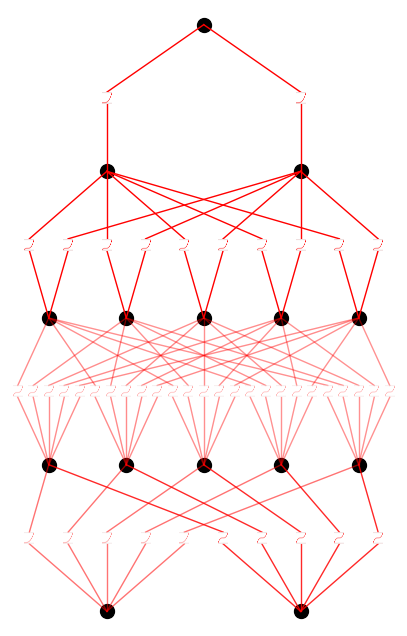

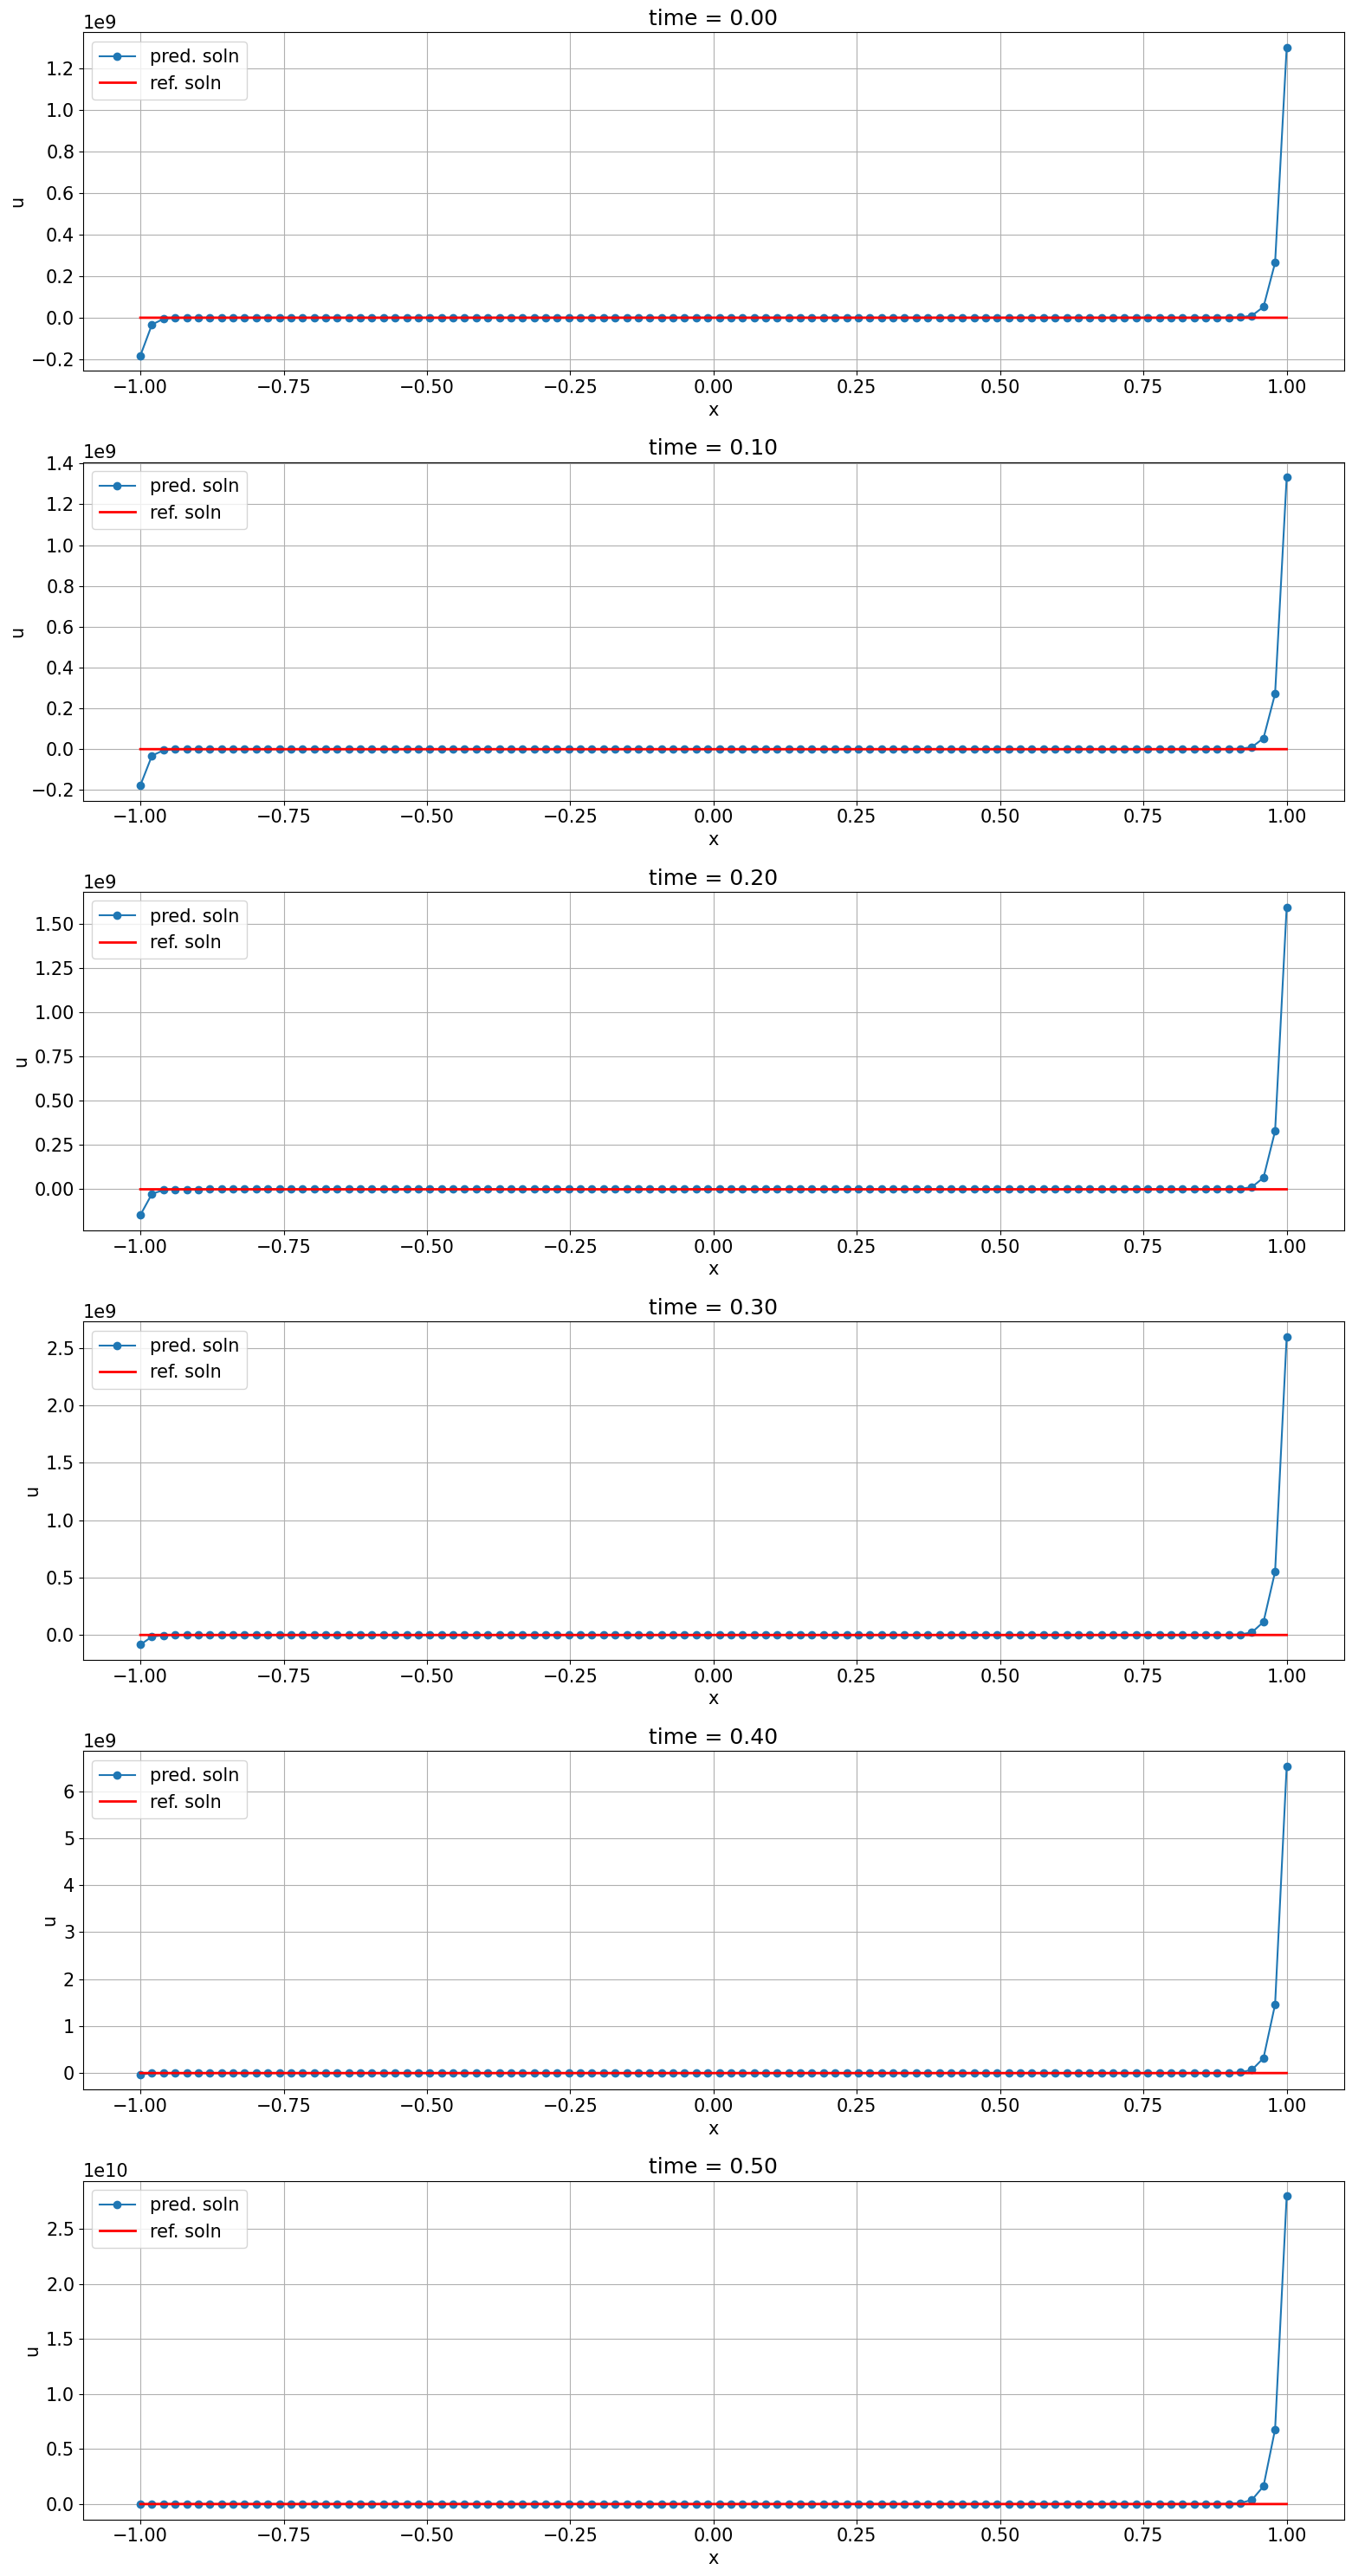

In [ ]:
# for i in range(2):
#     for j in range(3):
#         model.fix_symbolic(0,i,j,'x^3')

# for i in range(3):
#     for j in range(3):
#         model.fix_symbolic(1,i,j,'x^3')

# for i in range(3):
#     for j in range(2):
#         model.fix_symbolic(2,i,j,'x^3')

# for i in range(2):
#     model.fix_symbolic(3,i,0,'x^3')

# Example use of fix_symbolic with checks
for l in range(model.depth):
    for i in range(model.width[l]):
        for j in range(model.width[l+1]):
            try:
                print(f"Applying fix_symbolic at layer {l}, input neuron {i}, output neuron {j}")
                model.fix_symbolic(l, i, j, 'x^3', fit_params_bool=False)
                print(f"Successfully applied fix_symbolic at layer {l}, input neuron {i}, output neuron {j}")
            except Exception as e:
                print(f"Error applying fix_symbolic at layer {l}, input neuron {i}, output neuron {j}: {e}")


start_time = time.time()

train(steps)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

model.plot(beta=10)

formula, var = model.symbolic_formula(floating_digit=5)
print(formula[0])

# Visualization
df = pd.read_excel('Bergurs_Sol.xlsx', sheet_name='Sheet1', header=None)
Num_sol = torch.tensor(df.values, dtype=torch.float32)
t_sample = torch.tensor([0, .1, .2, .3, .4, .5])
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(t_sample), 1, figsize=(16, 5 * len(t_sample)))

for l, sample in enumerate(t_sample):
    t_test, x_test = torch.meshgrid(sample, x_train.squeeze())
    t_test = t_test.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)

    with torch.no_grad():
        pred_hist = model(torch.cat((t_test, x_test), dim=1)).detach().numpy()

    ax[l].plot(x_test.detach().numpy(), pred_hist, marker='o', label='pred. soln')
    ax[l].plot(Num_sol[0,:],Num_sol[l+1,:],'r-',lw=2,label='ref. soln')
    ax[l].set_xlabel('x')
    ax[l].set_ylabel('u')
    ax[l].grid()
    ax[l].legend()
    ax[l].set_title(f'time = {sample:.2f}')

fig.tight_layout()
plt.savefig('Burgers_Equation_KAN.jpeg', format='jpeg')